
为了实现图像拼接程序。我将按照以下步骤进行测试。

1. 提取图片SIFT特征
2. 对两张图片进行特征匹配
3. 对两张图片进行拼接
4. 合并拼接后的图片



步骤1 ： 提取图像SIFT特征，并且进行显示

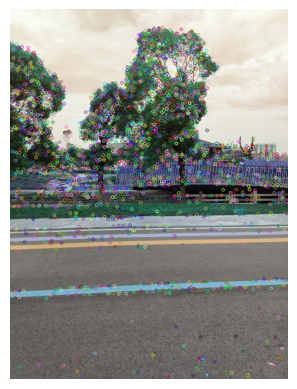

In [37]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


def extract_features(img, threshold=0.04):
    # 初始化SIFT检测器
    sift = cv2.SIFT_create(contrastThreshold=threshold)

    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 检测关键点和计算描述符
    keypoints, descriptors = sift.detectAndCompute(img, None)

    return keypoints, descriptors


# Load the image
image = cv2.imread("jpgs/1.jpg")
keypoints,_ = extract_features(image)
# Draw keypoints on the image
cv2.drawKeypoints(image, keypoints, image, flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT)
cv2.imwrite("sift_keypoints.jpg", image)
plt.imshow(image)
plt.axis("off")
plt.show()

步骤2：对两张图片进行特征匹配

In [38]:
import cv2


def match_images(img1, img2):

    # Detect keypoints and compute descriptors for both images
    keypoints1, descriptors1 = extract_features(img1)
    keypoints2, descriptors2 = extract_features(img2)

    # Initialize FLANN matcher
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Match descriptors using KNN matching
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    # Apply Lowe's ratio test to filter good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    # Draw matches
    # matched_img = cv2.drawMatches(
    #     img1,
    #     keypoints1,
    #     img2,
    #     keypoints2,
    #     good_matches,
    #     None,
    #     flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    # )

    return good_matches


# Example usage:
# img1 = cv2.imread("jpgs/1.jpg")
# img2 = cv2.imread("jpgs/2.jpg")
# matched_image = match_images(img1, img2)
# cv2.imwrite("Matched_Image.jpg", matched_image)
# plt.imshow(matched_image)
# plt.axis("off")
# plt.show()

步骤3：对两张图片进行拼接

通过使用之前匹配的关键点对，可以估计两张图片之间的几何变换。具体做法是寻找一个单应性矩阵，用来对齐坐标系。

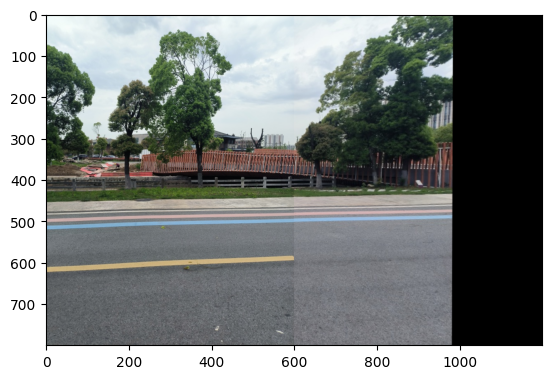

(<matplotlib.image.AxesImage at 0x18da4d53670>, None)

In [52]:
import cv2
import numpy as np


def stitch_images(img1,img2):

    # 提取特征点和计算描述符
    sift = cv2.SIFT_create(contrastThreshold=0.04)

    # 检测关键点和计算描述符
    keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

    # 匹配特征点
    matches_all = []
    good_matches = match_images(img1,img2)
    matches_all.append(good_matches)

    # 使用单应性矩阵拼接图片
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)

    # 计算单应性矩阵
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)

    # 对img1应用单应性变换
    warpimg = cv2.warpPerspective(
        img2, np.linalg.inv(M), (img1.shape[1] + img2.shape[1], img2.shape[0])
    )
    cv2.imwrite("warpimg.jpg", warpimg)
    warpimg[0:img1.shape[0], 0:img1.shape[1]] = img1
    return warpimg


# 示例用法：

img1 = cv2.imread("jpgs/1.jpg")
img2 = cv2.imread("jpgs/2.jpg")

stitched_image = stitch_images(img1,img2)
stitched_image = cv2.cvtColor(stitched_image, cv2.COLOR_BGR2RGB)
plt.imshow(img4), plt.show()

步骤四：优化拼接边界。上面的程序直接拼接图像导致边界处割裂比较明显，接下来采用代码进行优化.采用的方法为重叠部分加权平均。

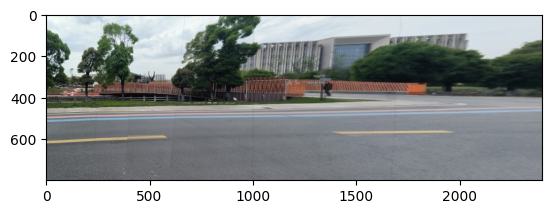

True

In [55]:
import cv2
import numpy as np


def stitch_images_plus(img1, img2):

    # 提取特征点和计算描述符
    sift = cv2.SIFT_create(contrastThreshold=0.04)

    # 检测关键点和计算描述符
    keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

    # 匹配特征点
    matches_all = []
    good_matches = match_images(img1, img2)
    matches_all.append(good_matches)

    # 使用单应性矩阵拼接图片
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(
        -1, 1, 2
    )
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(
        -1, 1, 2
    )

    # 计算单应性矩阵
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # 对img1应用单应性变换
    warpimg = cv2.warpPerspective(
        img2, np.linalg.inv(M), (img1.shape[1] + img2.shape[1], img2.shape[0])
    )
    cv2.imwrite("warpimg.jpg", warpimg)

    # 将img1和变换后的img2拼接
    rows, cols = img1.shape[:2]
    left = 0
    right = cols
    # 找到img1和warpimg重叠的最左边界
    for col in range(0, cols):
        if img1[:, col].any() and warpimg[:, col].any():
            left = col
        break
    # 找到img1和warpimg重叠的最右边界
    for col in range(cols - 1, 0, -1):
        if img1[:, col].any() and warpimg[:, col].any():
            right = col
        break
    # 图像融合
    res = np.zeros([rows, cols, 3], np.uint8)

    for row in range(0, rows):
        for col in range(0, cols):
            if not img1[row, col].any():
                res[row, col] = warpimg[row, col]
            elif not warpimg[row, col].any():
                res[row, col] = img1[row, col]
            else:
                # 重叠部分加权平均
                srcimgLen = float(abs(col - left))
                testimgLen = float(abs(col - right))
                alpha = srcimgLen / (srcimgLen + testimgLen)
                res[row, col] = np.clip(
                    img1[row, col] * (1 - alpha) + warpimg[row, col] * alpha, 0, 255
                )

    warpimg[0 : img1.shape[0], 0 : img1.shape[1]] = res

    img4 = cv2.cvtColor(warpimg, cv2.COLOR_BGR2RGB)
    plt.imshow(img4), plt.show()
    return warpimg


# 示例用法：

img1 = cv2.imread("stitched_image.jpg")
img2 = cv2.imread("jpgs/4.jpg")

stitched_image = stitch_images_plus(img1, img2)
cv2.imwrite("stitched_image.jpg", stitched_image)